# Initial Data ETL and EDA

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
# Loading
import json
# import pyspark
# from pyspark.sql import SparkSession

# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Basic text processing
import html
import re
import string
import pickle
# import spacy
# from common import vocabulary

# NLTK processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Additional processing
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from collections import Counter
from unicodedata import normalize
# from wordcloud import WordCloud

Data description: https://s3.amazonaws.com/amazon-reviews-pds/readme.html  
Data dictionary and download: https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt

__Note:__ The potential advantage of this data is that usefulness can be calculated as a proportion rather than an absolute. Whereas the original data only provides the total # of votes for usefulness, this data provides the total votes for usefulness and the total overall votes.

__DATA COLUMNS:__  
__marketplace__       - 2 letter country code of the marketplace where the review was written.  
__customer_id__       - Random identifier that can be used to aggregate reviews written by a single author.  
__review_id__         - The unique ID of the review.  
__product_id__        - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.  
__product_parent__    - Random identifier that can be used to aggregate reviews for the same product.  
__product_title__     - Title of the product.  
__product_category__  - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).  
__star_rating__       - The 1-5 star rating of the review.  
__helpful_votes__     - Number of helpful votes.  
__total_votes__       - Number of total votes the review received.  
__vine__              - Review was written as part of the Vine program.  
__verified_purchase__ - The review is on a verified purchase.  
__review_headline__   - The title of the review.  
__review_body__       - The review text.  
__review_date__       - The date the review was written.  

In [20]:
data_path = "../data/amazon_reviews_us_Electronics_v1_00.tsv"

# Line 9076 has an issue where the field and line separator is not recognized
electronics = pd.read_csv(data_path,
                          sep='\t',
                          nrows=5000,
                          on_bad_lines='skip'
                         )

electronics = electronics[['star_rating',
                           'helpful_votes',
                           'total_votes',
                           'review_headline',
                           'review_body'
                          ]]

electronics = electronics[electronics['total_votes'] > 0]
electronics = electronics[electronics['review_body'].notna()]

electronics['helpful_ratio'] = electronics['helpful_votes'] / electronics['total_votes']
electronics['helpful_ratio'] = electronics['helpful_ratio'].fillna(0)
electronics['useful'] = electronics['helpful_ratio'].apply(lambda x: 1 if x >= 0.7 else 0)
electronics

,star_rating,helpful_votes,total_votes,review_headline,review_body,helpful_ratio,useful
2,5,1,1,Five Stars,Works pissa,1.0,1
4,5,1,1,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,1.0,1
5,5,1,1,Five Stars,The quality on these speakers is insanely good...,1.0,1
13,5,0,1,Five Stars,Excellent gain in radio frequency reception ov...,0.0,0
18,2,4,5,It does not copy CD-R s to USB as advertised ...,It does not copy CD-R s to USB as advertised. ...,0.8,1
...,...,...,...,...,...,...,...
4948,4,1,1,Nice basic phones with mediocre sound quality,I received these as a free review sample. I'll...,1.0,1
4950,3,1,1,Product is OK. Security straps have to be atta...,Product is OK. Security straps have to be att...,1.0,1
4951,2,0,2,Two Stars,OK.,0.0,0
4973,5,1,1,Love this brand of batteries,Love this brand of batteries. I charge them a...,1.0,1


In [21]:
electronics['useful'].value_counts()

1    732
0    506
Name: useful, dtype: int64

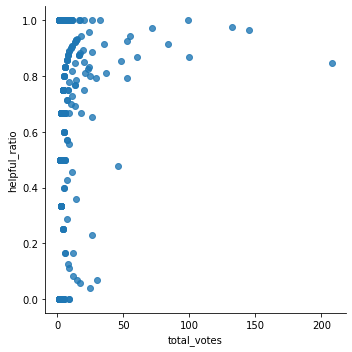

In [22]:
sns.lmplot(x='total_votes', y='helpful_ratio', data=electronics, fit_reg=False).set(title='')
plt.show()

### X.X Text processing

In [23]:
electronics = electronics.rename(columns={'review_body':'review_text'})

__Clean up text with basic standard procedures - will apply to baseline models and BERT__

In [24]:
# Example review
print(electronics["review_text"].iloc[0])
print("")

# Remove special characters
pattern = r"\&\#[0-9]+\;"

electronics["review_text"] = electronics["review_text"].str.replace(pat=pattern, repl="", regex=True)

# Replace linebreak symbol with space
pattern = "<br />"
electronics["review_text"] = electronics["review_text"].str.replace(pat=pattern, repl=" ", regex=True)

# Remove extra spaces
pattern = r"[\s]+"
electronics["review_text"] = electronics["review_text"].str.replace(pat=pattern, repl=" ", regex=True)

# Example review
print(electronics["review_text"].iloc[0])

Works pissa

Works pissa


__Lemmatization - craete a new field called 'review_procesed' to separate what will be used for baselines and BERT__

In [25]:
# Use lemmatization to reduce words to their root form

# import nltk resources
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource, quiet=True)

In [26]:
%%time
# create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

# apply functions to review text
electronics["review_processed"] = electronics["review_text"].apply(lambda row: lemmatize_doc(row))

# Example review
print(electronics["review_text"].iloc[1])
print("")
print(electronics["review_processed"].iloc[1])
print("")

Works well. Bass is somewhat lacking but is present. Overall pleased with the item.

Works well Bass be somewhat lacking but be present Overall please with the item

CPU times: user 5.5 s, sys: 296 ms, total: 5.8 s
Wall time: 5.95 s


__Non-standard text processing decisions - again for baselines, but not BERT__

In [27]:
# Remove accents
remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
electronics["review_processed"] = electronics["review_processed"].apply(remove_accent)

# Remove punctuation
pattern = r"[^\w\s]"
electronics["review_processed"] = electronics["review_processed"].str.replace(pat=pattern, repl=" ", regex=True)

# Convert to lowercase
electronics["review_processed"] = electronics["review_processed"].str.lower()

# Remove stopwords
stop_words = stopwords.words("english")
stop_words = [word.replace("\'", "") for word in stop_words]
# print(f"sample stop words: {stop_words[:15]} \n")

remove_stop_words = lambda row: " ".join([token for token in row.split(" ") if token not in stop_words])
electronics["review_processed"] = electronics["review_processed"].apply(remove_stop_words)

# Example review
print(electronics["review_text"].iloc[0])
print("")
print(electronics["review_processed"].iloc[0])

Works pissa

works pissa


In [28]:
electronics.to_csv('../data/electronics.csv')

__How to use BERT for classification__  
CLS token  
SEP (separator) token  
Need a softmax if it is multi-class  
Feed this into an output layer above BERT

In [29]:
electronics['review_text'].isna().value_counts()

False    1238
Name: review_text, dtype: int64